In [118]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import torch as ch
import numpy as np
import os
import torch.nn as nn
import argparse
import seaborn as sns
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from mib.models.utils import get_model
from mib.utils import get_models_path
from mib.dataset.utils import get_dataset
from mib.train import get_loader, train_model, evaluate_model
from sklearn.model_selection import train_test_split
from mib.attacks.theory_new import compute_hessian, fast_ihvp, ProperTheoryRef
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from torch_influence.modules import HVPModule, LiSSAInfluenceModule, CGInfluenceModule
from torch_influence.base import BaseObjective

In [120]:
target_model_index = 0

In [4]:
model_arch = "lr_mse" # "mlp_mnistodd_mse" #"lr_mse"

In [5]:
# Load model and take note of relevant data
model, criterion, hparams = get_model(model_arch, 1)
base_dir = f"/p/distinf/mib_cache/models/mnistodd/{model_arch}/"
model_dict = ch.load(os.path.join(base_dir, f"{target_model_index}.pt"))
model.load_state_dict(model_dict["model"], strict=False)
model.eval()
model.cuda()

MLPQuadLoss(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [6]:
learning_rate = hparams['learning_rate']
batch_size = hparams['batch_size']

In [7]:
train_index = model_dict["train_index"]
test_index  = model_dict["test_index"]
N = len(train_index)

In [277]:
class MyObjective(BaseObjective):
    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return criterion(outputs.squeeze(1), batch[1].float())

    def train_regularization(self, params):
        return 0

    def test_loss(self, model, params, batch):
        return criterion(model(batch[0]).squeeze(1), batch[1].float())  # no regularization in test loss

In [8]:
pkeep = 0.5
ds = get_dataset("mnistodd")()

train_data = ds.get_train_data()
test_data  = ds.get_test_data()

train_loader = get_loader(train_data, train_index, 512)

In [9]:
def get_specific_grad(model, point_x, point_y):
    model.zero_grad()
    logits = model(point_x.cuda())
    loss = criterion(logits, point_y.unsqueeze(0).float().cuda())
    ret_loss = loss.item()
    loss.backward()
    flat_grad = []
    for p in model.parameters():
        flat_grad.append(p.grad.detach().view(-1))
    flat_grad = ch.cat(flat_grad)
    model.zero_grad()
    return flat_grad, ret_loss

In [10]:
def collect_grad_on_all_data(model, loader):
    cumulative_gradients = None
    for x, y in loader:
        # Zero-out accumulation
        model.zero_grad()
        # Compute gradients
        x, y = x.cuda(), y.cuda()
        loss = criterion(model(x).squeeze(), y.float()) * len(x)
        loss.backward()
        flat_grad = []
        for p in model.parameters():
            flat_grad.append(p.grad.detach().view(-1))
        # Flatten out gradients
        flat_grad = ch.cat(flat_grad)
        # Accumulate in higher precision
        if cumulative_gradients is None:
            cumulative_gradients = ch.zeros_like(flat_grad, dtype=ch.float64)
        cumulative_gradients += flat_grad
    model.zero_grad()
    cumulative_gradients /= N
    return cumulative_gradients

In [11]:
# Can collect 'all gradients' and then construct each n-1 setting from that
all_data_grad = collect_grad_on_all_data(model, train_loader)

In [13]:
exact_H = compute_hessian(model, train_loader, criterion, device = "cuda")

In [256]:
exact_H_touse = exact_H.cpu().clone().detach()
# Compute SVD and add epsilon noise to non-zero eigenvalues
L, Q = ch.linalg.eigh(exact_H_touse)
eps = 1e-1
print(f"{ch.sum(1 * (L >= eps))} out of {L.shape[0]} eigenvalues are above {eps}!")
effective_rank = ch.sum(L > eps).item()

4 out of 785 eigenvalues are above 0.1!


In [257]:
# Use one of these two methods

# Low-rank approximation
qualifying_indices = ch.abs(L) > eps
exact_H_touse = Q[:, qualifying_indices] @ ch.diag(L[qualifying_indices]) @ Q[:, qualifying_indices].T
H_inverse = Q[:, qualifying_indices] @ ch.diag(1 / L[qualifying_indices]) @ Q[:, qualifying_indices].T

# Damping
# L += eps
# exact_H_touse = Q @ ch.diag(L) @ Q.T
# H_inverse = Q @ ch.diag(1 / L) @ Q.T

In [258]:
H_inverse = H_inverse.double()

In [ ]:
ch.sum((H_inverse @ exact_H_touse.double()) - ch.eye(H_inverse.shape[0]))

In [ ]:
grad, _ = get_specific_grad(model, train_data[2][0], train_data[2][1])
actual_relevant_ihvp = (H_inverse @ grad.cpu()).cuda()

In [ ]:
# Compute ihvp with LiSSA
module = LiSSAInfluenceModule(
    model=model,
    objective=MyObjective(),
    train_loader=train_loader,
    test_loader=None,
    device="cuda",
    damp=0.01,
    repeat=20,
    depth=100, #5000 for MLP and Transformer, 10000 for CNN
    scale=25
)

In [ ]:
sims, diffs = [], []
for i in tqdm(range(10)):
    grad, _ = get_specific_grad(model, train_data[i][0], train_data[i][1])
    actual_relevant_ihvp = (H_inverse @ grad.cpu()).cuda()
    ihvp = module.inverse_hvp(grad)
    cosine_sim = nn.functional.cosine_similarity(ihvp.unsqueeze(0), actual_relevant_ihvp.unsqueeze(0)).item()
    normdiff = (ch.abs(ch.norm(ihvp) - ch.norm(actual_relevant_ihvp))).item()
    print(cosine_sim, normdiff)
    sims.append(cosine_sim)
    diffs.append(normdiff)

In [ ]:
print(np.mean(sims), "+/-", np.std(sims))
print(np.mean(diffs), "+/-", np.std(diffs))

In [ ]:
ihvp = module.inverse_hvp(grad)
ihvp_relevant = ihvp[smart_choice_indices]

In [ ]:
cosine_sim = nn.functional.cosine_similarity(ihvp_relevant.unsqueeze(0), actual_relevant_ihvp.unsqueeze(0)).item()
l2 = ch.norm(ihvp_relevant - actual_relevant_ihvp, 2).item()
normdiff = (ch.abs(ch.norm(ihvp_relevant) - ch.norm(actual_relevant_ihvp))).item()
print(cosine_sim, l2, normdiff)

- with 100 scale:
  - 0.7142822265625 +/- 0.05192919844409316
  - 11.936937987059355 +/- 17.92897013951449

- with 50 scale:
  - 0.6452893555164337 +/- 0.13971037275996379
  - 11.851892096363008 +/- 17.80627659719628
 
- with 10 repeats, 50 depth (instead of 20, 100):
  - 0.6861703723669053 +/- 0.07222075119409092
  - 11.920574374683202 +/- 17.905135836344748
 
- with 10 repeats, 100 depth:
  - 0.6689350426197052 +/- 0.09797662330058511
  - 11.896501280367374 +/- 17.870331110053517

- with 20 repeats, 50 depth:
  - 0.6867498099803925 +/- 0.06983868197260762
  - 11.920660879649223 +/- 17.90530133194961

- with 15 repeats, 75 depth:
  - 0.6755705744028091 +/- 0.08577207715673675
  - 11.908260511234403 +/- 17.8873053670706

In [ ]:
print(ch.norm(ch.diagonal(exact_H_touse @ H_inverse) - ch.ones(exact_H_touse.shape[0]), 2))
print(ch.norm((exact_H_touse @ H_inverse) - ch.eye(exact_H_touse.shape[0]), 2))

In [363]:
"""
ihvp_module = CGInfluenceModule(
    model=model,
    objective=MyObjective(),
    train_loader=train_loader,
    test_loader=None,
    device="cuda",
    damp=1e-2,
)
"""
ihvp_module = LiSSAInfluenceModule(
    model=model,
    objective=MyObjective(),
    train_loader=train_loader,
    test_loader=None,
    device="cuda",
    repeat=2,
    depth=500, #5000 for MLP and Transformer, 10000 for CNN
    scale=25,
    damp=1e-2,
)
# """

In [364]:
def specific_point_test(idx, train: bool = True, approx: bool = False):
    if train:
        point_x, point_y = train_data[idx]
    else:
        point_x, point_y = test_data[idx]
    
    grad, ret_loss = get_specific_grad(model, point_x, point_y)
    grad = grad.double()

    if train:
        all_other_data_grad = (all_data_grad * len(train_index) - grad) / (len(train_index) - 1)
    else:
        all_other_data_grad = all_data_grad

    #print(all_other_data_grad)
    if approx:
        datapoint_ihvp = ihvp_module.inverse_hvp(grad)
        ihvp_alldata   = ihvp_module.inverse_hvp(all_other_data_grad)
    else:
        datapoint_ihvp = (H_inverse @ grad.cpu()).cuda()
        ihvp_alldata   = (H_inverse @ all_other_data_grad.cpu()).cuda()
    
    I2 = ch.dot(datapoint_ihvp, datapoint_ihvp).cpu().item() / len(train_index)
    I3 = ch.dot(ihvp_alldata, datapoint_ihvp).cpu().item() * 2
    model.zero_grad()

    I2, I3 = I2 / learning_rate, I3 / learning_rate
    
    # Also compute self-influence score
    self_influence = ch.dot(grad, datapoint_ihvp).cpu().item()

    return I2, I3, ret_loss, self_influence

In [365]:
APPROX = True
NUM_POINTS = 10

In [366]:
I2s, I3s, losses, SIF = [], [], [], []
for i in tqdm(range(NUM_POINTS)):
    i2, i3, loss, sif = specific_point_test(i, approx=APPROX)
    I2s.append(i2)
    I3s.append(i3)
    losses.append(loss)
    SIF.append(sif)

I2s = np.array(I2s)
I3s = np.array(I3s)
losses = np.array(losses)
SIF = np.array(SIF)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:30<00:00, 15.08s/it]


In [367]:
I2s_test, I3s_test, losses_test, SIF_test = [], [], [], []
for i in tqdm(range(NUM_POINTS)):
    i2, i3, loss, sif = specific_point_test(i, train = False, approx=APPROX)
    I2s_test.append(i2)
    I3s_test.append(i3)
    losses_test.append(loss)
    SIF_test.append(sif)

I2s_test = np.array(I2s_test)
I3s_test = np.array(I3s_test)
losses_test = np.array(losses_test)
SIF_test = np.array(SIF_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:31<00:00, 15.14s/it]


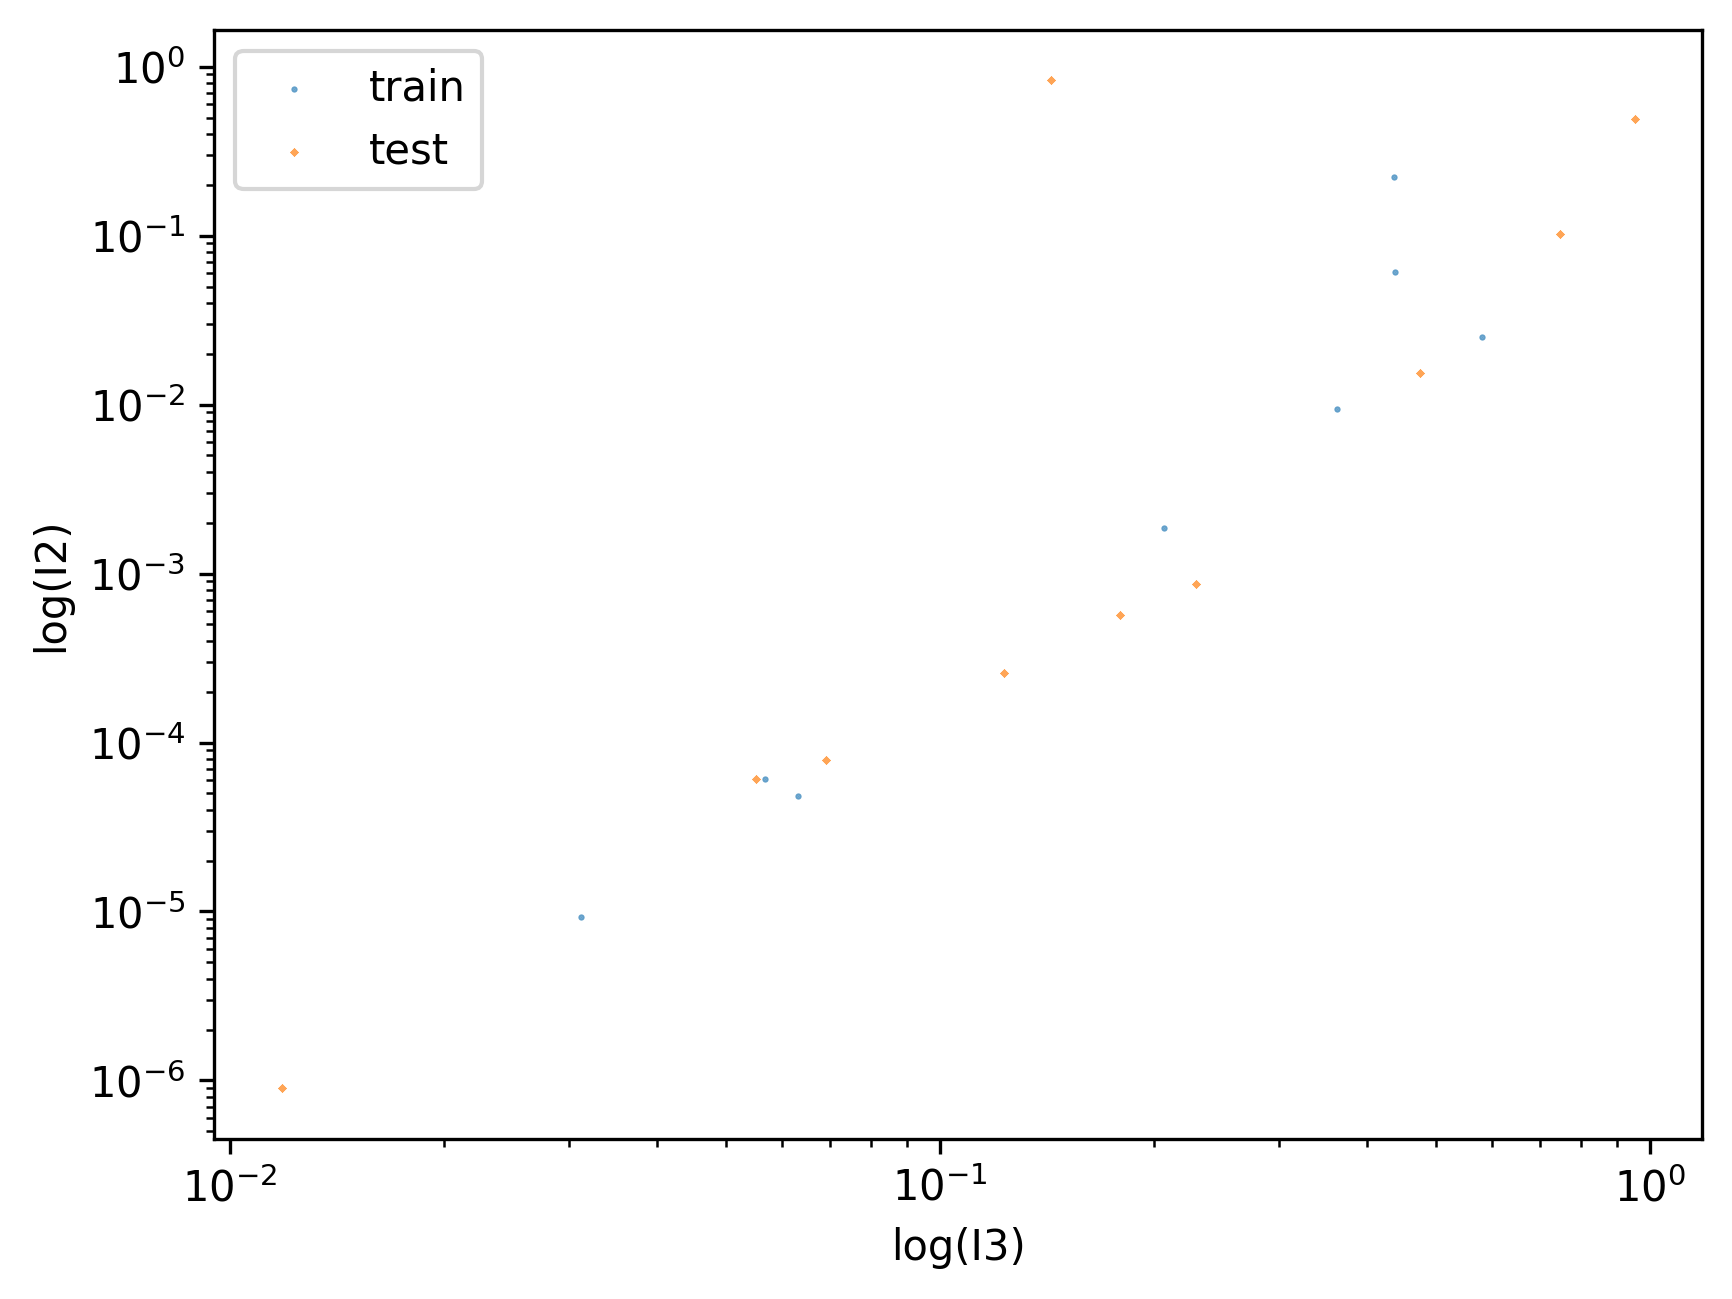

In [368]:
plt.scatter(I3s, I2s, label="train", marker='.', s=1, alpha=0.7)
plt.scatter(I3s_test, I2s_test, label="test", marker='x', s=1, alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("log(I3)")
plt.ylabel("log(I2)")
plt.legend()

In [369]:
valid = I3s > 0
valid_te = I3s_test > 0

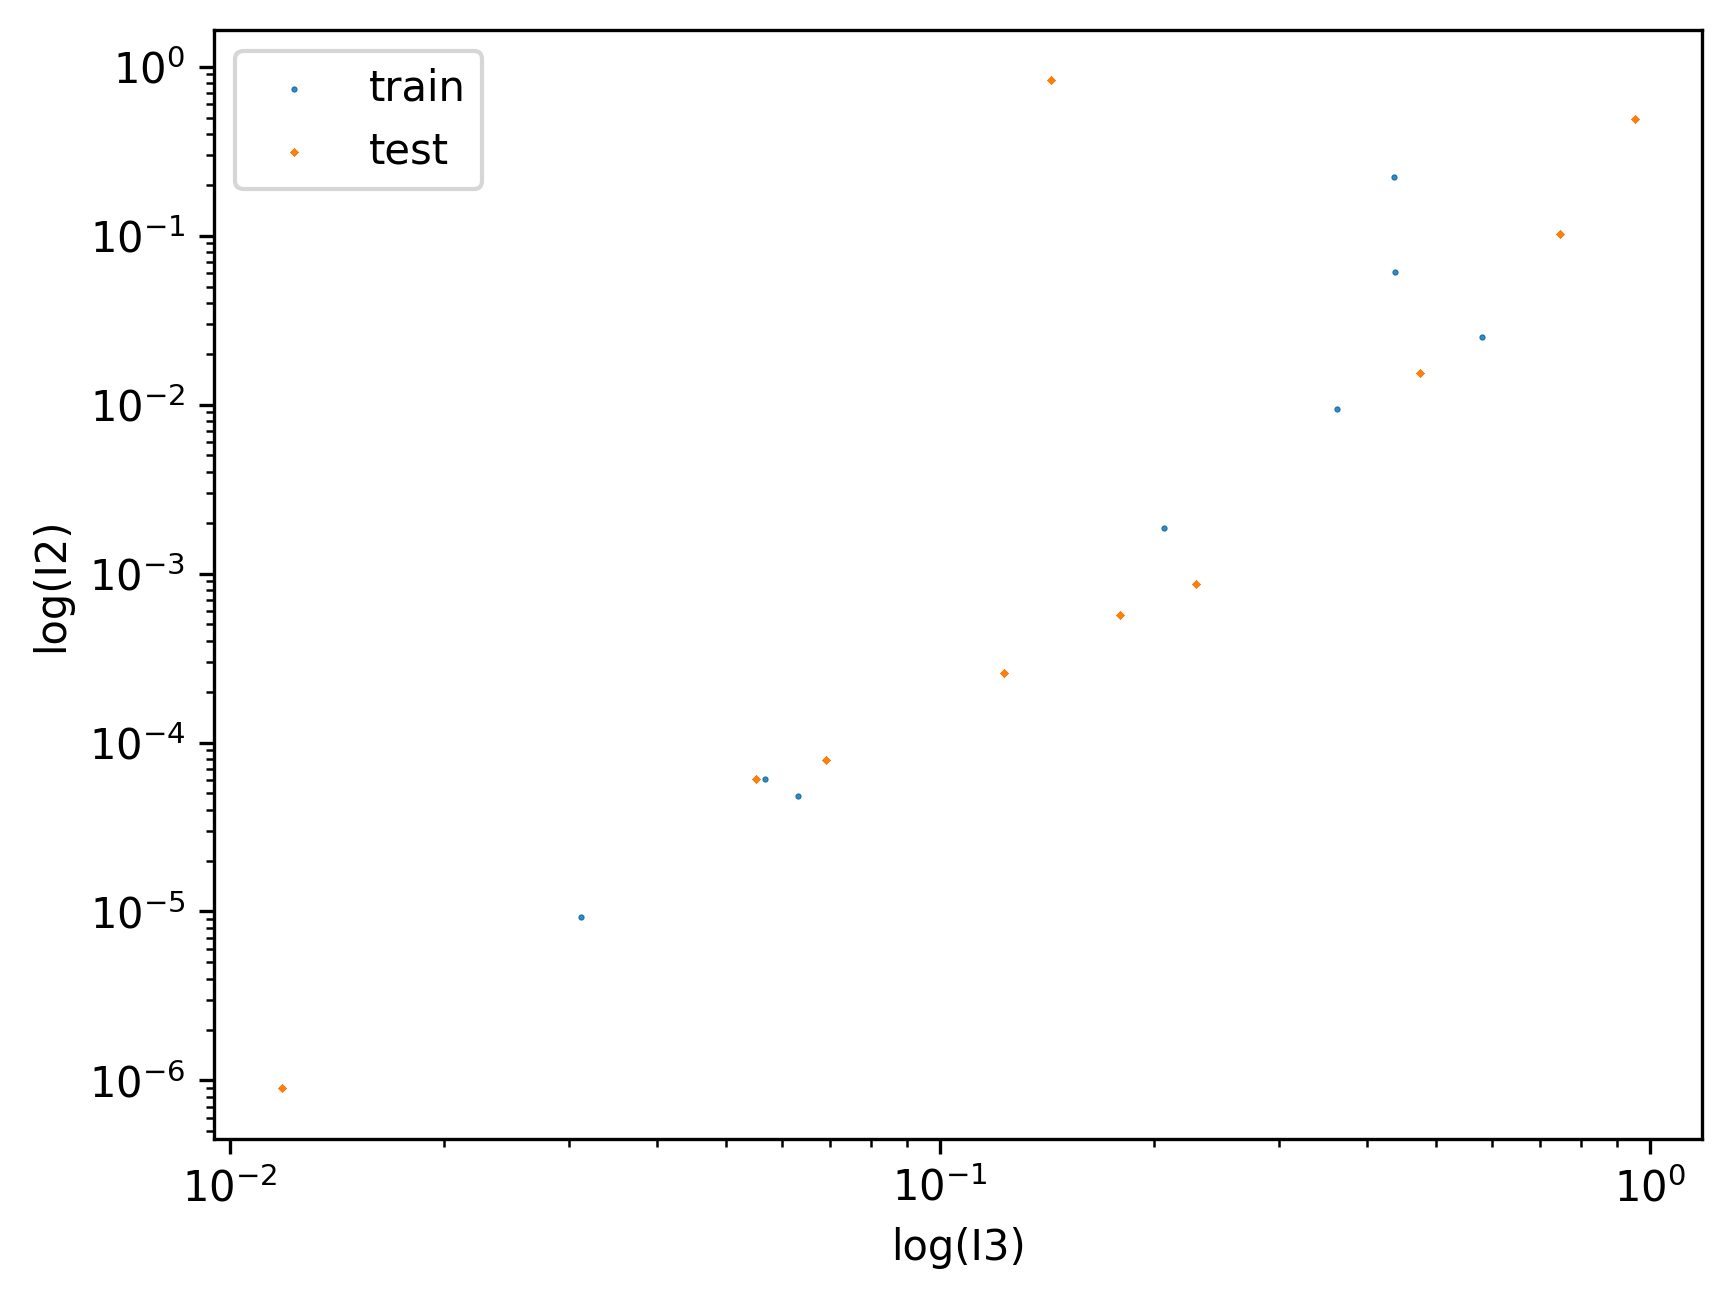

In [370]:
plt.scatter(I3s[valid], I2s[valid], label="train", marker='.', s=1)
plt.scatter(I3s_test[valid_te], I2s_test[valid_te], label="test", marker='x', s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("log(I3)")
plt.ylabel("log(I2)")
plt.legend()

In [371]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(I3s[valid]),np.log(I2s[valid]))
slope_te, intercept_te, r_value, p_value, std_err = stats.linregress(np.log(I3s_test[valid_te]),np.log(I2s_test[valid_te]))

print(slope, slope_te)
print(intercept, intercept_te)

3.19500362178607 2.82463053289871
-0.7233450890412527 -1.1462898387794418


Imagine this intercept is used to distinguish between train and test

In [372]:
in_bw_intercept = (intercept + intercept_te) / 2
in_bw_slope = (slope + slope_te) / 2

classify_tr = (np.log(I2s[valid]) - (np.log(I3s[valid]) * in_bw_slope + in_bw_intercept)) > 0
classify_te = (np.log(I2s_test[valid_te]) - (np.log(I3s_test[valid_te]) * in_bw_slope + in_bw_intercept)) < 0
acc = (np.sum(classify_tr) + np.sum(classify_te)) / (len(classify_tr) + len(classify_te))
print("Acc:", acc)

Acc: 0.5


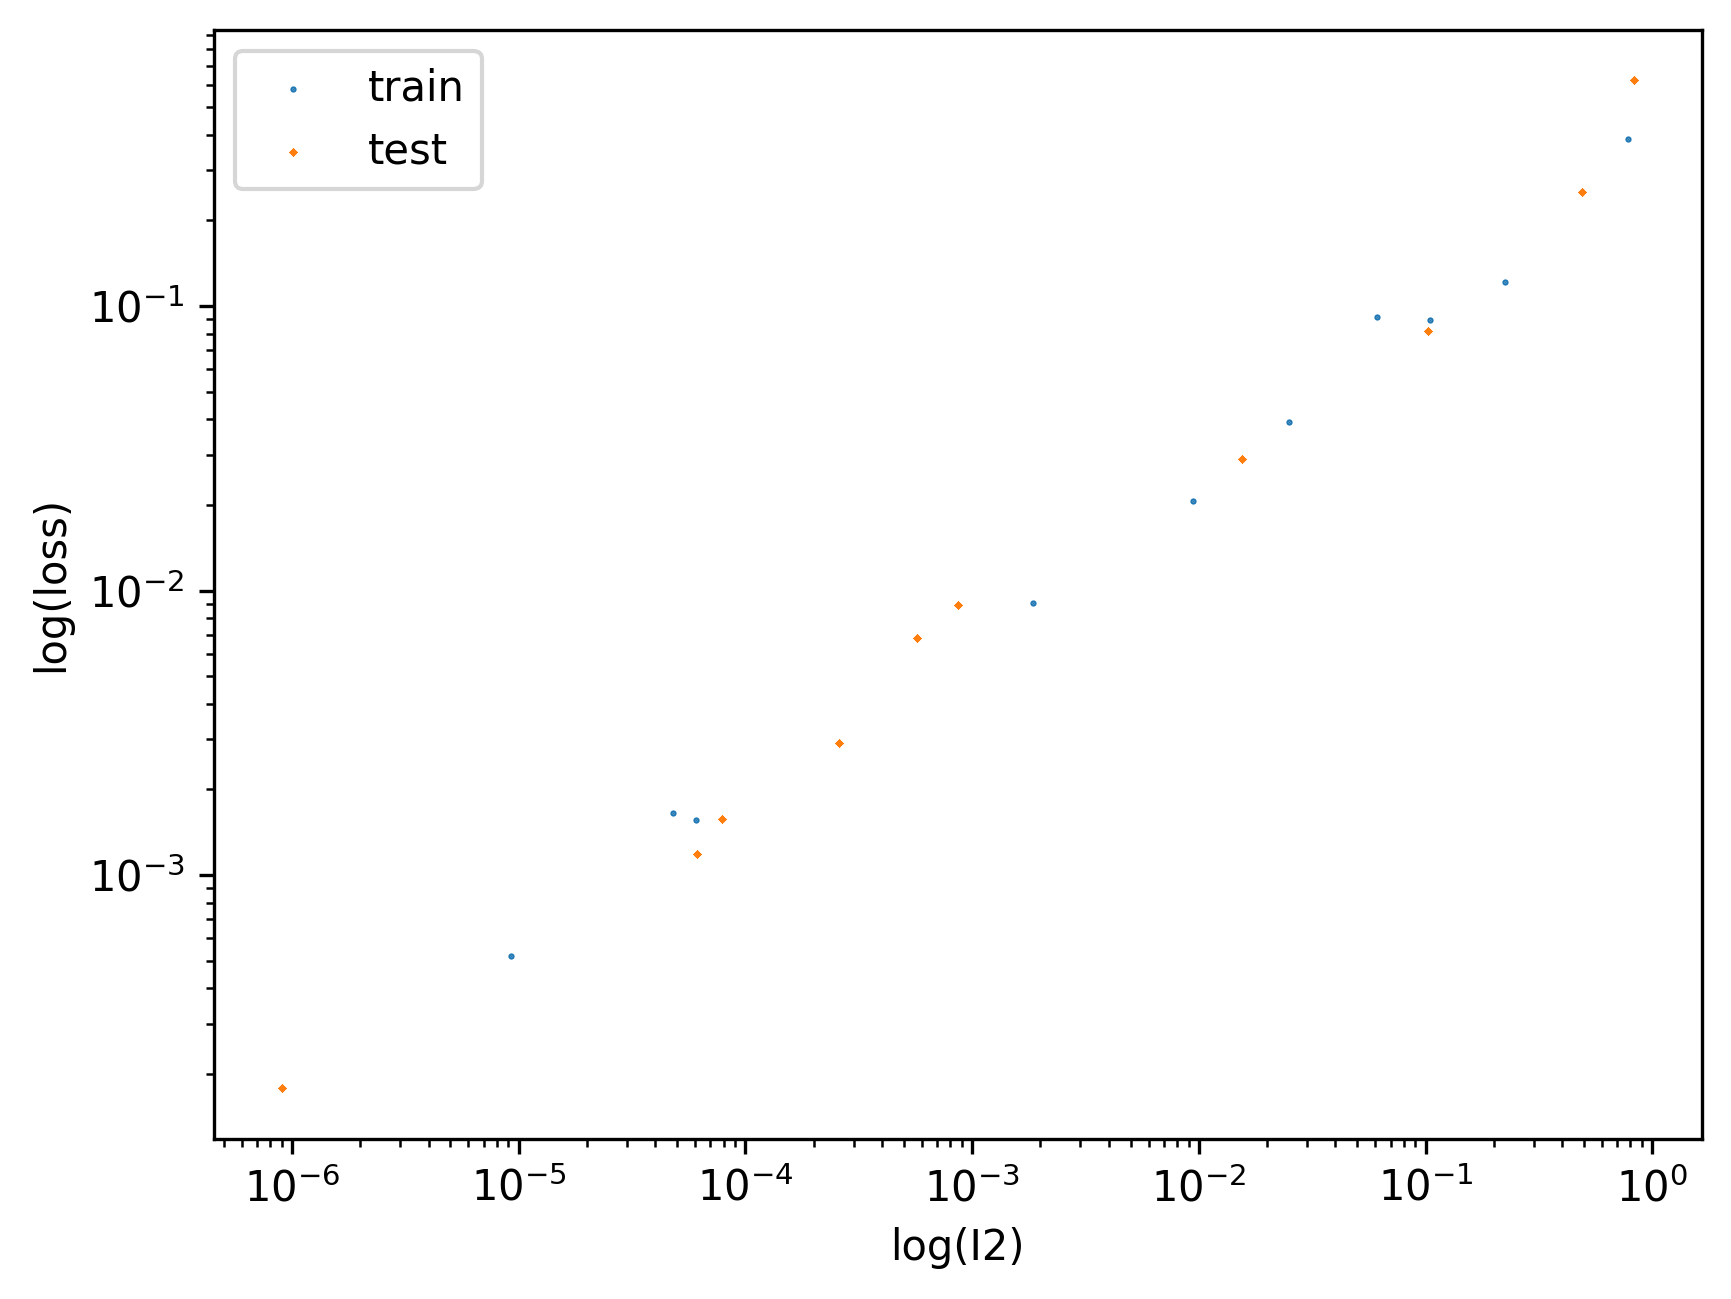

In [373]:
plt.scatter(I2s, losses, label="train", marker='.', s=1)
plt.scatter(I2s_test, losses_test, label="test", marker='x', s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("log(I2)")
plt.ylabel("log(loss)")
plt.legend()

### Rough comparison of MIA scores

In [374]:
losses_sc = losses #/ len(train_index)
losses_test_sc = losses_test #/ len(train_index)

In [375]:
scores = losses_sc - (I2s + I3s)
scores_test = losses_test_sc - (I2s_test + I3s_test)

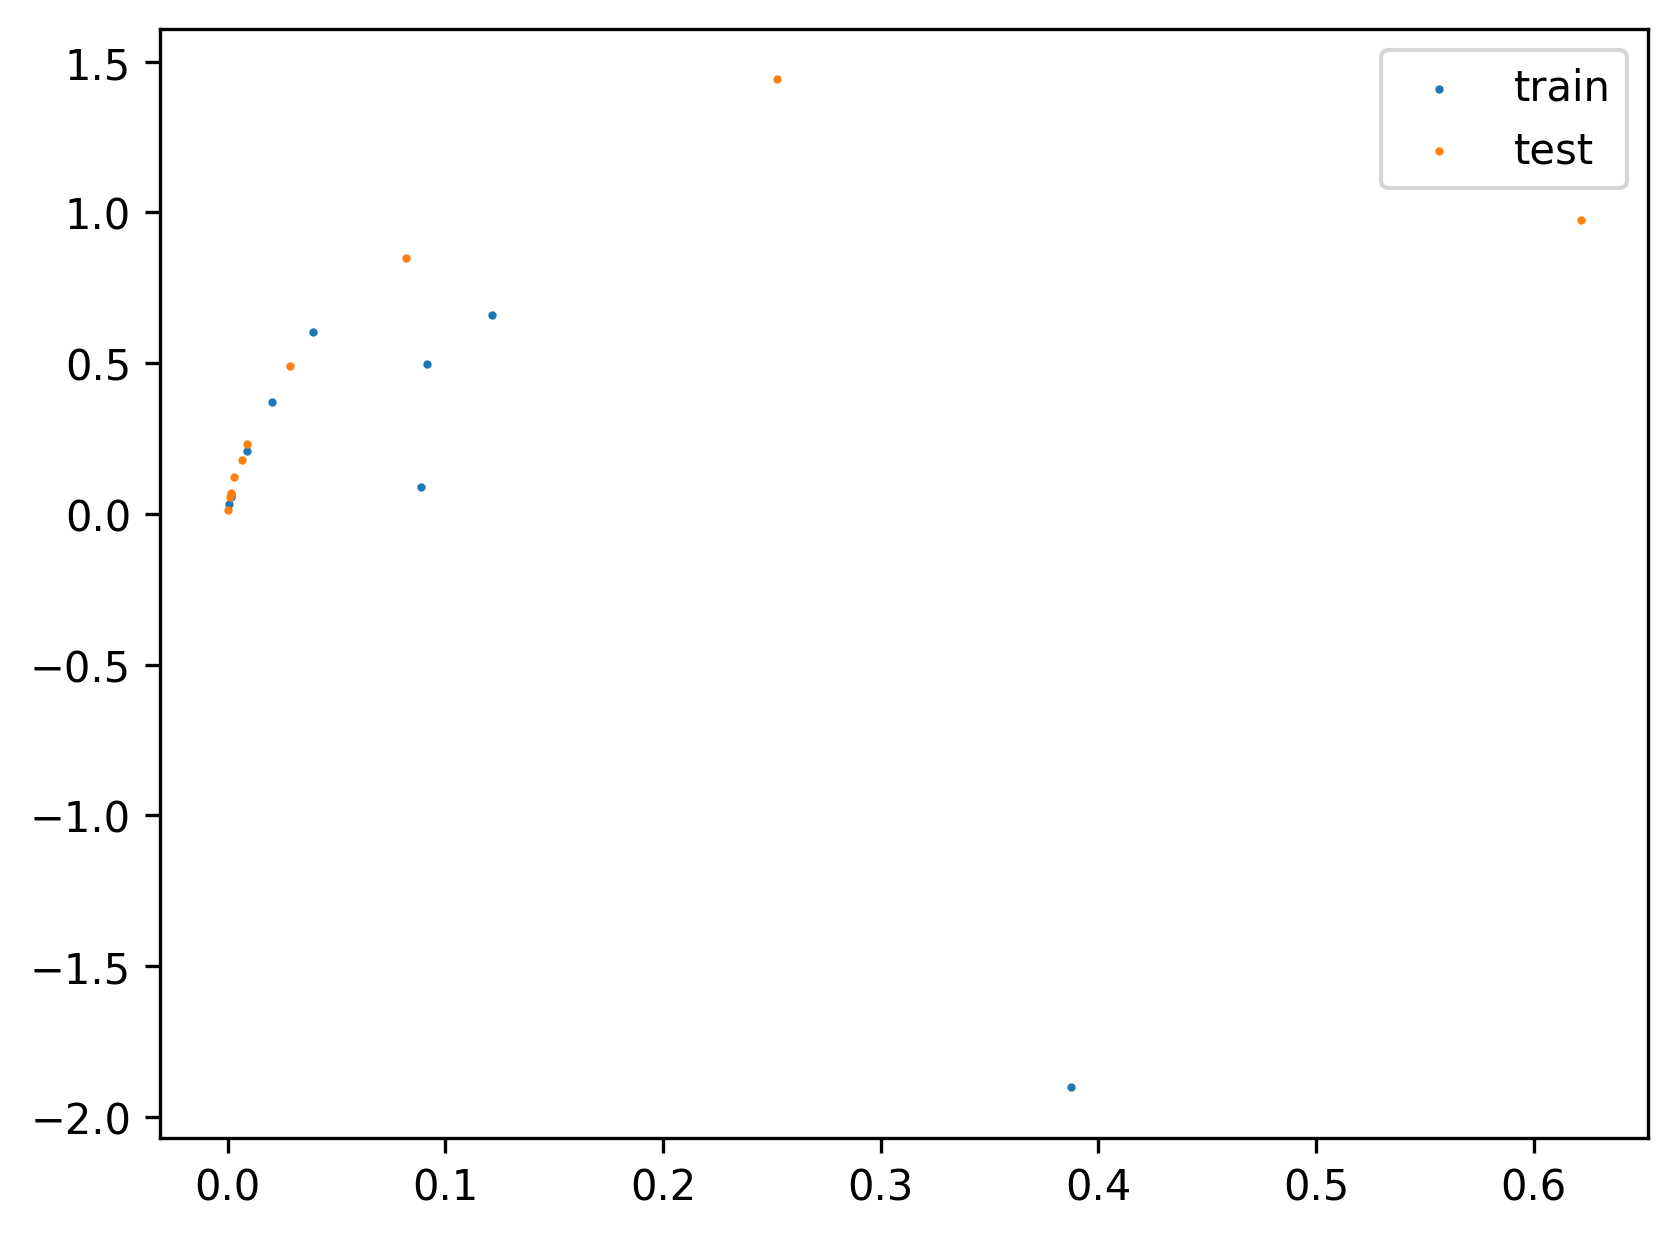

In [376]:
plt.scatter(losses_sc, I2s + I3s, s=1, label="train")
plt.scatter(losses_test_sc, I2s_test + I3s_test, s=1, label="test")
plt.legend()

In [377]:
total_labels = [1] * len(losses) + [0] * len(losses_test)

In [378]:
# total_preds = - np.concatenate((losses, losses_test))
total_preds = np.concatenate((scores, scores_test))

In [379]:
fpr, tpr, thresholds = roc_curve(total_labels, total_preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.61


#### Approximation (10 points)
- LiSSA (20 repeat, 100 depth): 0.52
- LiSSA (5 repeat, 100 depth): 0.52
- LiSSA (2 repeat, 500 depth): 0.61
- LiSSA (2 repeat, 1000 depth): 0.58
- CG: 0.61

#### LOSS
- 0.52422532

#### Damping based
- 1e-3: 0.51635844
- 1e-2: 0.51635844
- 1e-1: 0.5442899600000001
- 1.5e-1: 0.54674144

#### Selection based
- 1e-4: 0.50558652
- 1e-3: 0.503768
- 1e-2: 0.53574052
- 1e-1: 0.5156678

In [121]:
attacker = ProperTheoryRef(model, criterion=criterion, all_train_loader=train_loader)

In [108]:
scores = []
for i in tqdm(range(NUM_POINTS)):
    x, y = train_data[i]
    score = attacker.compute_scores(
        x, y,
        learning_rate=learning_rate,
        num_samples=N,
        is_train=True)
    scores.append(score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.25it/s]

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.3886e-10,  2.9993e-09,  2.9993e-09,
         1.2497e-10,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  6.8926e-10,  2.0498e-09,  1.8277e-07,
         3.5868e-07,  3.7936e-06,  2.6461e-06,  1.3704e-06,  6.1267e-07,
         6.4142e-07,  8.1205e-07,  1.0634e-06,  1.2146e-06,  1.8112e-06,
         9.4965e-07,  5.9530e-07,  6.6390e-07,  4.5188e-07,  3.5632e-07,
         5.5052e-08,  2.0525e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  5.8294e-08,
         4.8444e-09,  3.9589e-09,  2.7605e-07,  1.8707e-06,  1.4784e-05,
         2.1809e-05,  3.2077e-05,  2.6539e-05,  2.8

In [122]:
scores_test = []
for i in tqdm(range(NUM_POINTS)):
    x, y = test_data[i]
    score = attacker.compute_scores(
        x, y,
        learning_rate=learning_rate,
        num_samples=N,
        is_train=False)
    scores_test.append(score)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 667.18it/s]

0.0001780477468855679 1.0923473198323563e-06 0.015261009684763849
0.0011869913432747126 7.44189314384789e-05 0.07092012092471123
0.008927266113460064 0.0010453900458788122 0.28310148045420647
0.0015730502782389522 9.31258101067638e-05 0.0892910931725055
0.02888483926653862 0.0186463144681113 0.5666329525411129
0.006813457701355219 0.0006623422157669334 0.21532310638576746
0.2525216341018677 0.5917768301085703 1.3055898249149323
0.00291077746078372 0.0003192410767804582 0.15566486399620771
0.6215184330940247 1.0112587626266314 0.6511278450489044
0.08195298165082932 0.12315592041137863 0.8506982587277889


In [ ]:
0.0001780477468855679 1.0923471564765868e-06 0.015261010039495329
0.0011869913432747126 7.441893064382439e-05 0.07092012873411035
0.008927266113460064 0.0010453900170740089 0.2831015200279315
0.0015730502782389522 9.312580557496423e-05 0.08929110626046971
0.02888483926653862 0.018646315403590377 0.5666327147466536
0.006813457701355219 0.0006623422063420614 0.21532308969477296
0.2525216341018677 0.5917768008029753 1.3055874229852364
0.00291077746078372 0.0003192410976748795 0.15566488196338063
0.6215184330940247 1.0112587835626747 0.6511328895462902
0.08195298165082932 0.1231559135645335 0.850697877152546

In [ ]:
total_preds = np.concatenate((scores, scores_test))
fpr, tpr, thresholds = roc_curve(total_labels, total_preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)

Text(0.5, 0, '$loss - (I_2 + I_3)$')

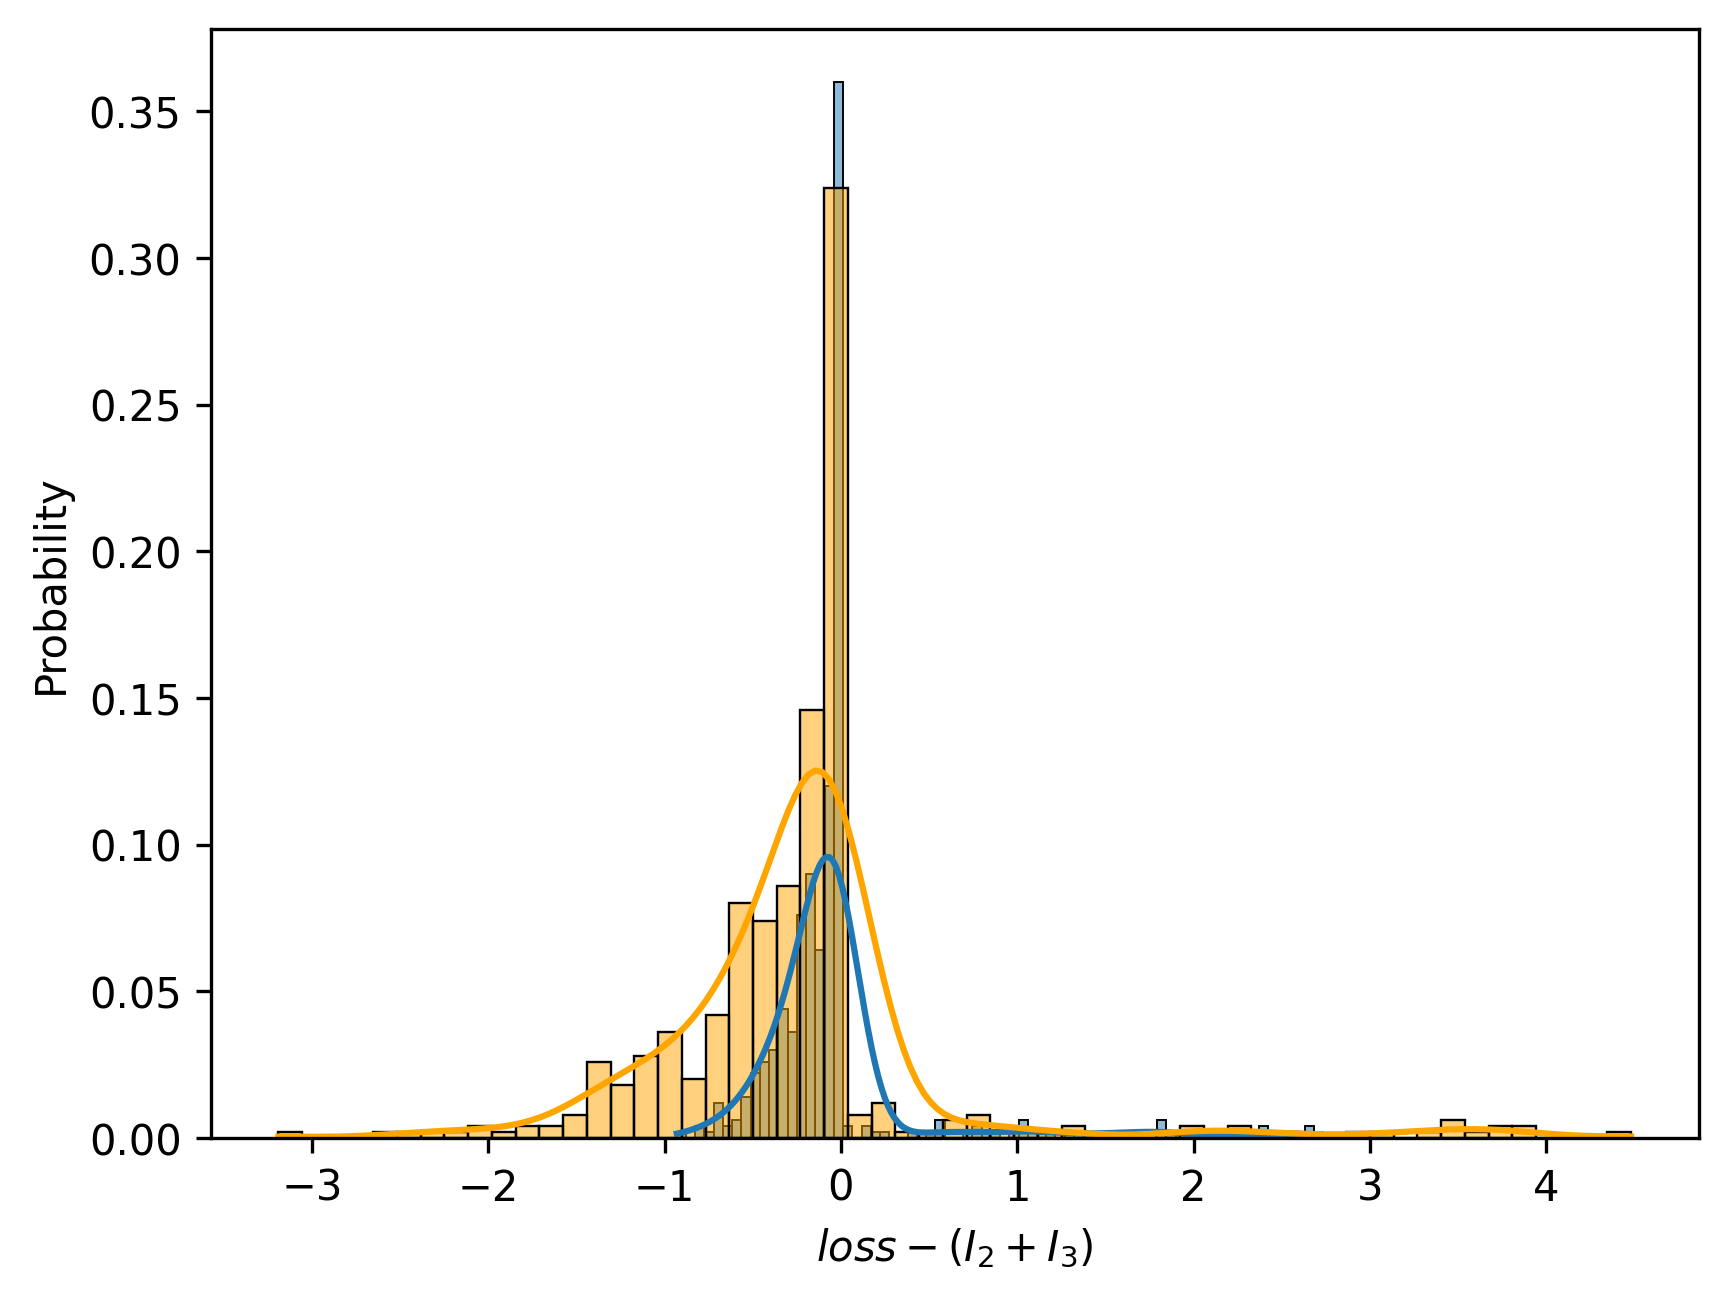

In [70]:
sns.histplot(scores, kde=True, stat='probability')
sns.histplot(scores_test, kde=True, color="orange", stat='probability')
plt.xlabel(r"$loss - (I_2 + I_3)$")

In [ ]:
sns.histplot(np.log(I2s), kde=True)
sns.histplot(np.log(I2s_test), kde=True, color="orange")
plt.xlabel(r"$\log(losses + I2s)$")

# Covariance hypothesis

Break covariance into two terms, one with rank r and other with rank D - r

In [ ]:
flat_params = []
evals, evectors = [], []

for i in tqdm(range(25)):
    # Load model and take note of relevant data
    model, criterion, hparams = get_model(model_arch, 1)
    loo_base_dir = f"/p/distinf/mib_cache/models/mnistodd/{model_arch}/l_mode/0/0/"
    model_dict = ch.load(os.path.join(loo_base_dir, f"{i}.pt"))
    model.load_state_dict(model_dict["model"], strict=False)
    model.eval()
    flat_param = []
    for p in model.parameters():
        flat_param.append(p.detach().view(-1))
    flat_params.append(ch.cat(flat_param))
    
    # Also look at their Hessians
    model.cuda()
    train_index = model_dict["train_index"]
    test_index  = model_dict["test_index"]
    N = len(train_index)
    train_loader = get_loader(train_data, train_index, 512)
    test_loader  = get_loader(test_data, test_index, 512)
    all_data_grad = collect_grad_on_all_data(model, train_loader)
    exact_H = compute_hessian(model, train_loader, criterion, device = "cuda")
    exact_H_touse = exact_H.cpu().clone().detach()
    # Compute SVD and add epsilon noise to non-zero eigenvalues
    L, Q = ch.linalg.eigh(exact_H_touse)
    evals.append(L)
    evectors.append(Q)

flat_params = ch.stack(flat_params, 0)
evals = ch.stack(evals, 0)
evectors = ch.stack(evectors, 0)

In [ ]:
mean = ch.mean(flat_params, 0)
flat_params_norm = flat_params - mean
cov = (flat_params_norm.T @ flat_params_norm) / (flat_params.shape[0] - 1)

In [ ]:
cov.shape

In [ ]:
pick_rank = ch.min(ch.sum(evals > 0, 1))
print(f"r={pick_rank}, D={flat_params.shape[1]}")

In [ ]:
cov

In [ ]:
s, u = ch.linalg.eigh(cov)
cov_r = u[:, :pick_rank] @ ch.diag(s[:pick_rank]) @ u[:, :pick_rank].T

In [ ]:
cov_r
s.shape

In [ ]:
L_star = 0.08

In [ ]:
prefix_const = (2 * learning_rate * L_star) / batch_size

In [ ]:
for u, v in zip(evals, evectors):
    # H = v[:, :pick_rank] @ ch.diag(u[:pick_rank]) @ v[:, :pick_rank].T
    H = v @ ch.diag(u) @ v.T
    inner = ch.linalg.inv(2 * ch.eye(H.shape[0]) - learning_rate * H)
    s, u = ch.linalg.eigh(inner)
    inner = u[:, :pick_rank] @ ch.diag(s[:pick_rank]) @ u[:, :pick_rank].T
    supposed_term = prefix_const * inner
    print(supposed_term)
    break
    # Compare this with P_r cov
    print(H)
    print(ch.norm(cov_r - supposed_term))